# Анализ GeoReviews Dataset от Яндекс Карт

Ссылка на github с датасетом: https://github.com/yandex/geo-reviews-dataset-2023#geo-reviews-dataset-2023

Этот ноутбук решает следующие задачи:
1. анализирует новый открытый датасет с отзывами от Яндекс Карт
2. дает первое представление о его возможностях и ограничениях
3. Формирует более "чистый" датасет
4. Показывает возможность преобразования адресов в координаты

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

from shapely.geometry import Point, Polygon

import numpy as np
import geopandas as gpd

from shapely.geometry import shape

from matplotlib import pyplot as plt

### Трансформация tskv к табличному формату  ###

In [3]:
file_name = "../geo-reviews-dataset-2023.tskv"

In [4]:
df = pd.read_csv( file_name, header=None, sep='\t')

In [5]:
df.head()

,0,1,2,3,4
0,"address=Екатеринбург, ул. Московская / ул. Вол...",name_ru=Московский квартал,rating=3.,rubrics=Жилой комплекс,text=Московский квартал 2.\nШумно : летом по н...
1,"address=Московская область, Электросталь, прос...",name_ru=Продукты Ермолино,rating=5.,rubrics=Магазин продуктов;Продукты глубокой за...,"text=Замечательная сеть магазинов в общем, хор..."
2,"address=Краснодар, Прикубанский внутригородско...",name_ru=LimeFit,rating=1.,rubrics=Фитнес-клуб,"text=Не знаю смутят ли кого-то данные правила,..."
3,"address=Санкт-Петербург, проспект Энгельса, 11...",name_ru=Snow-Express,rating=4.,rubrics=Пункт проката;Прокат велосипедов;Сапсё...,text=Хорошие условия аренды. \nДружелюбный пер...
4,"address=Тверь, Волоколамский проспект, 39",name_ru=Студия Beauty Brow,rating=5.,"rubrics=Салон красоты;Визажисты, стилисты;Сало...",text=Топ мастер Ангелина топ во всех смыслах )...


In [6]:
df.shape

(500000, 5)

In [7]:
normal_cols = []
df_edited = pd.DataFrame()
for col in df.columns:
    col_name = df[col][0].split('=')[0]
    df_edited[col_name] = df[col].apply(lambda x: x if isinstance(x, float) else '='.join(x.split('=')[1:]))
    normal_cols.append(col_name)

In [8]:
df_edited.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


###  Распределение по адресам, рубрикам и рейтингам ###

**Распределение числа отзывов**

<Axes: ylabel='Frequency'>

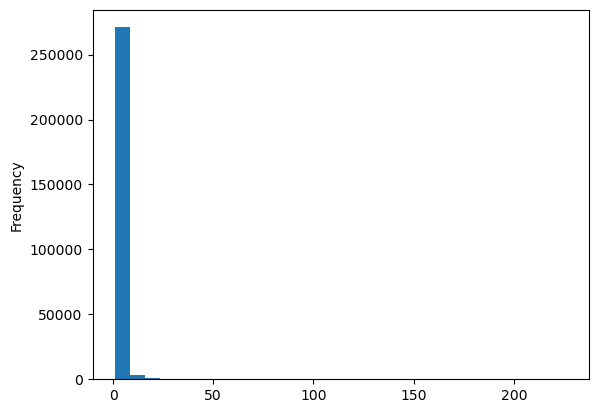

In [49]:
df_edited.groupby(['address','name_ru'])['rubrics'].size().plot(kind='hist', bins=30)

**Распределение числа организаций**

<Axes: ylabel='Frequency'>

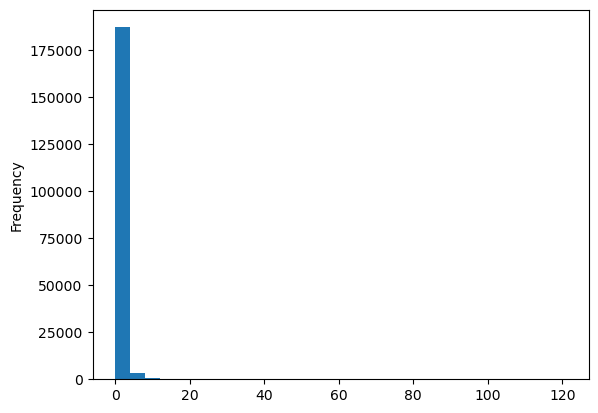

In [114]:
df_edited.groupby(['address'])['name_ru'].nunique().plot(kind='hist', bins=30)

**Проверим 2 случайных адреса на ЯК, чтобы проверить, полное ли у нас число организаций**

In [80]:
from random import sample

In [91]:
list_index = sample(sorted(df_edited.address.unique()), k=2)

In [92]:
list_index

['Москва, улица Генерала Тюленева, 25', 'Краснодар, улица Селезнёва, 193/1']

In [93]:
df_edited[df_edited.address.isin(list_index)]

,address,name_ru,rating,rubrics,text,region,rating_ok,name
36759,"Москва, улица Генерала Тюленева, 25",Япкупил,5.0,Радиоуправляемые и стендовые модели,Отличный магазин. Обращалась несколько раз. Об...,Москва,5.0,NaN
36760,"Москва, улица Генерала Тюленева, 25",Япкупил,5.0,Радиоуправляемые и стендовые модели,Давно мечтал о раллийной легенде - но полномас...,Москва,5.0,NaN
164153,"Краснодар, улица Селезнёва, 193/1",Скол-Сервис,5.0,Автостёкла,Самая адыкватная цена! Делаю на протяжении 3-х...,Краснодар,5.0,NaN
291672,"Краснодар, улица Селезнёва, 193/1",Экосмотр,5.0,Пункт техосмотра;Страхование автомобилей,"Всё чётко, своё дело знают",Краснодар,5.0,NaN


Согласно ЯК по адресу 'Москва, улица Генерала Тюленева, 25' находятся 2 организации: Япкупил и Алкомаркет - в датасете Алкомаркет отсутствует.   
По адресу 'Краснодар, улица Селезнёва, 193/1' находятся 2 организации: Скол-Сервис, Экосмотр. Обе есть в датасете.

**Убираем ошибку в рейтинге** 

In [55]:
df_edited['rating'].value_counts()

rating
5.                                                                                  389693
4.                                                                                   41116
1.                                                                                   34298
3.                                                                                   21652
2.                                                                                   12071
                                                                                     ...  
Жилой комплекс                                                                           1
Оптовая компания;Швейное предприятие                                                     1
Компьютерный ремонт и услуги;Ремонт телефонов;Ремонт аудиотехники и видеотехники         1
Фитнес-клуб;Студия йоги;Спортивный, тренажёрный зал                                      1
Магазин цветов;Копировальный центр;Товары для праздника                            

In [61]:
df_edited['rating_ok'] = df_edited['rating'].apply(lambda x: float(x[0]))

In [63]:
df_edited[~df_edited['rating_ok'].apply(lambda x: x.isnumeric())]

,address,name_ru,rating,rubrics,text,region,rating_ok
322,"Москва, 8-я улица Соколиной Горы, 15А, стр. 23",5.,Офис организации,"Ребята профи!\n\nОтлично подобрали модель, съе...",NaN,Москва,О
5716,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,"Гостиница действительно хорошая, удобно распол...",NaN,Челябинская область,Г
5717,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,Был здесь на кулинарном мастер-классе. Место а...,NaN,Челябинская область,Г
5718,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,"Тихое место, в выходные возможно и шумно так к...",NaN,Челябинская область,Г
5719,"Челябинская область, Златоуст, Таганайская ули...",5.,Гостиница,"Воспитанные и отзывчивые официанты , вкусная к...",NaN,Челябинская область,Г
...,...,...,...,...,...,...,...
498536,"Республика Башкортостан, Уфа, улица Менделеева...",5.,"Скалодром;Спортивный клуб, секция",Были с детьми на 8 марта. Приехали специально ...,NaN,Республика Башкортостан,С
498688,"Москва, Юго-Восточный административный округ, ...",5.,Изготовление памятников и надгробий;Изделия из...,"Отличное качество материала, прекрасное исполн...",NaN,Москва,И
498913,"Самарская область, Волжский район, жилой район...",1.,Магазин цветов;Копировальный центр;Товары для ...,"Цен на цветы которые находятся на витрине нет,...",NaN,Самарская область,М
499006,"Волгоград, улица Гроссмана, 6",5.,Салон красоты,Квалифицированные мастера. Работу выполняют с ...,NaN,Волгоград,С


In [64]:
df_wrong = df_edited[~df_edited['rating_ok'].apply(lambda x: x.isnumeric())]

In [65]:
df_edited.columns

Index(['address', 'name_ru', 'rating', 'rubrics', 'text', 'region',
       'rating_ok'],
      dtype='object')

In [94]:
df_wrong.columns = ['address', 'rating', 'rubrics', 'text', "name_ru",'region',
       'rating_ok']

In [99]:
df_edited_new = pd.concat([df_edited.drop(df_wrong.index), df_wrong])

In [100]:
df_edited_new.columns

Index(['address', 'name_ru', 'rating', 'rubrics', 'text', 'region',
       'rating_ok'],
      dtype='object')

**Проверяем**

In [102]:
df_edited_new[~df_edited_new['rating'].apply(lambda x: str(x)[0].isnumeric())]

,address,name_ru,rating,rubrics,text,region,rating_ok


In [105]:
df_edited_new['rating_ok'] = df_edited_new['rating'].apply(lambda x: float(x[0]))

In [106]:
df_edited = df_edited_new.copy()

In [107]:
df_edited['rating'] = df_edited['rating_ok']

**Распределение оценок**

<Axes: ylabel='Frequency'>

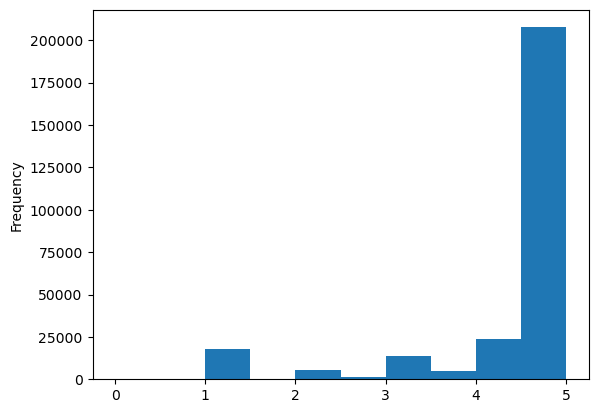

In [111]:
df_edited.groupby(['address','name_ru'])['rating'].mean().plot(kind='hist', bins=10)

**Топ рубрик**

In [152]:
df_rubrics = pd.DataFrame(df_edited["rubrics"].apply(lambda x: x.split(";")).tolist())

In [176]:
df_full_list_rubricks = df_rubrics.stack()

<Axes: >

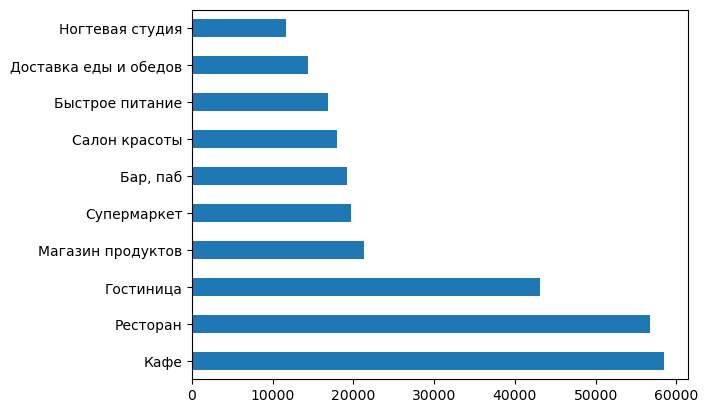

In [166]:
df_full_list_rubricks.value_counts().head(10).plot(kind='barh')

**Что можно еще сделать:**
 - Посмотреть распределение средней оценки по рубрикам
 - Посмотреть число отзывов по каждой рубрике

# География

### Добавление геометрии для 3000 уникальных адресов ###

In [20]:
!pip install geopy

In [9]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point

In [10]:
def get_point(your_loc):
    t=0
    while t<5:
        try:
            obj = app.geocode(your_loc)
            if obj is not None:
                y= obj.latitude
                x= obj.longitude
                return Point(x,y)
            else:
                return None
        except:
            t=t+1
    return None

In [ ]:
app = Nominatim(user_agent="my-app")

In [20]:
df_unique = df_edited[['address']].drop_duplicates()

In [15]:
import tqdm

In [23]:
n=1
for ind, adr in tqdm.tqdm(df_unique['address'][:3000].items()):
    df_unique.loc[ind,'geometry'] = get_point(adr)
    if n%50 ==0:
        df_unique.iloc[n-50:n].to_csv("georeviews.csv",mode='a', index=False, header=False)
    n+=1

3000it [26:58,  1.85it/s]


In [27]:
df_geometry = pd.read_csv("georeviews.csv", header=None)

Для 615 адресов не нашлось координат в OSM

In [30]:
df_geometry.isnull().sum()

0      0
1    615
dtype: int64

In [31]:
df_geometry = df_geometry.dropna()

In [35]:
df_geometry.columns = ["address","geometry"]

In [37]:
from shapely import wkt

In [38]:
df_geometry["geometry"]= df_geometry["geometry"].apply(wkt.loads)

In [39]:
gdf_geometry = gpd.GeoDataFrame(df_geometry, crs = 'epsg:4326', geometry = 'geometry')

### Разброс по географии ###

In [40]:
gdf_geometry.explore()

In [131]:
from folium import plugins
from folium.plugins import HeatMap

In [145]:
map_heat = folium.Map(location=[ 55, 75.5074,],
                    zoom_start = 3) 

In [137]:
gdf_geometry['Latitude'] = gdf_geometry['geometry'].y
gdf_geometry['Longitude'] = gdf_geometry['geometry'].x

In [146]:

heat_data = [[row['Latitude'],row['Longitude']] for index, row in gdf_geometry.iterrows()]
HeatMap(heat_data).add_to(map_heat)
map_heat

In [213]:
gdf_geometry_full = gdf_geometry.merge(df_edited, on='address', how='inner')

In [221]:
gdf_geometry_full.to_file("georeviews_wth_geometry.geojson", driver='GeoJSON')

(12746, 10)

**Что еще можно сделать**
 -  Добавить геометрию регионов и построть choropleth с различными стат показателями

## Распределение по городам ##

In [43]:
df_edited['region'] = df_edited['address'].apply(lambda x: x.split(',')[0])

In [113]:
df_edited["region"].value_counts().head(20)

region
Москва                     104774
Санкт-Петербург             52568
Московская область          49953
Краснодарский край          29646
Республика Татарстан        11662
Свердловская область        11617
Краснодар                    9073
Нижний Новгород              8545
Ленинградская область        8409
Республика Крым              8128
Ростов-на-Дону               7781
Ставропольский край          6452
Республика Башкортостан      6246
Самара                       5735
Ростовская область           5631
Воронеж                      5457
Новосибирск                  4972
Волгоград                    3821
Калининград                  3663
Ярославль                    3589
Name: count, dtype: int64

**Cколько всреднем организаций приходится на один адрес**

In [122]:
df_org_address = (df_edited.groupby(["region"])["name_ru"].nunique()/df_edited.groupby(["region"])["address"].nunique()).rename('avg_count_org').to_frame()

In [126]:
df_org_address = df_org_address.join(df_edited.groupby(["region"])["address"].nunique().rename("count_address"))

In [189]:
mask=df_org_address.count_address>5

In [190]:
df_org_address[mask].sort_values("avg_count_org", ascending=False)

,avg_count_org,count_address
region,,
городской округ Волгоград,1.888889,9
городской округ Владимир,1.571429,14
городской округ Рязань,1.400000,10
Карачаево-Черкесская Республика,1.385621,306
городской округ Красноярск,1.375000,8
...,...,...
Томский район,0.868421,38
Пермский край,0.865136,697
Ростовская область,0.861706,3037


**Самые популярные рубрики в каждом городе**

In [178]:
df_full_list_rubricks = df_full_list_rubricks.reset_index().drop('level_1', axis=1).set_index('level_0')

In [181]:
df_full_list_rubricks.columns =['rubric']

In [182]:
df_full_rubrics_addresses = df_edited[['address','region']].join(df_full_list_rubricks)

In [183]:
df_full_rubrics_addresses.shape

(929973, 3)

In [184]:
df_full_rubrics_addresses

,address,region,rubric
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Екатеринбург,Жилой комплекс
1,"Московская область, Электросталь, проспект Лен...",Московская область,Магазин продуктов
1,"Московская область, Электросталь, проспект Лен...",Московская область,Продукты глубокой заморозки
1,"Московская область, Электросталь, проспект Лен...",Московская область,"Магазин мяса, колбас"
2,"Краснодар, Прикубанский внутригородской округ,...",Краснодар,Фитнес-клуб
...,...,...,...
499997,"Новосибирск, Коммунистическая улица, 48А",Новосибирск,Магазин цветов
499997,"Новосибирск, Коммунистическая улица, 48А",Новосибирск,Копировальный центр
499997,"Новосибирск, Коммунистическая улица, 48А",Новосибирск,Товары для праздника
499998,"Астраханская область, Харабалинский район",Астраханская область,Салон красоты


In [198]:
df_rubrics_regions  = df_full_rubrics_addresses.groupby(['region','rubric'])['address'].size().rename('count')

In [201]:
df_rubrics_regions_best = df_rubrics_regions.reset_index().set_index('region')[mask]

/var/folders/5p/s8yf3c6n5_1_qnj_m1bgc7x80000gn/T/ipykernel_59074/1215681992.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rubrics_regions_best = df_rubrics_regions.reset_index().set_index('region')[mask]


In [205]:
df_rubrics_regions_best['rank'] = df_rubrics_regions_best.groupby(level=0)['count'].rank(ascending=False, method='first')

In [208]:
df_rubrics_regions_best_sorted = df_rubrics_regions_best[df_rubrics_regions_best['rank'] <10].sort_values(['region','rank'])

In [210]:
df_rubrics_regions_best_sorted.head()

,rubric,count,rank
region,,,
Алтайский край,Ресторан,280,1.0
Алтайский край,Кафе,258,2.0
Алтайский край,Гостиница,211,3.0
Алтайский край,Магазин продуктов,95,4.0
Алтайский край,Супермаркет,93,5.0


In [209]:
df_rubrics_regions_best_sorted.to_csv("most_popular_pois_by_region.csv")